In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 1000)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from utils import createXYPlot
from utils import getVariables
from datetime import datetime
from typing import List, Optional

today = str(datetime.now().date())
print(today)
plots_folder = f"./plots/{today}/iss"
os.system(f"mkdir -p {plots_folder}")

2022-04-16


0

In [2]:
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
COLORS

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [36]:
def plot_incidence(split, age, colors, linestyles: Optional[List[str]] = None):
    createXYPlot(df_plt,
             x="data",
             y=["no_vax_100k",
                "vax_100k",
                "1_dose_100k",
                "2_dosi_lt_cut_100k", 
                "2_dosi_gt_cut_100k", 
                "booster_100k"],
                colors=colors,
                error=True,
                alpha_err=0.1,
                labels=["non vaccinati",
                        "vaccinati",
                        "1 dose",
                        "2_dosi < 120gg",
                        "2_dosi > 120gg",
                        "booster"],
                plots_folder=plots_folder,
                linestyles=linestyles,
                title=f"Incidenza {split} mensili per 100k - dati ISS - {age}",
                figsize_x=10,
                figsize_y=5,
                dpis=90,
                linewidth=1.5,
                ytitle=f"N. {s} per 100k".replace("_"," "),
                savename=f"incidenza_{split}_{age}_per_100k",
                days_interval=1)

In [40]:
def plot_efficacy(age, split, 
                  start_date: Optional[str] = None,
                  cat: Optional[List[str]] = None, 
                  labels: Optional[List[str]] = None,
                  colors: Optional[List[str]] = None,
                  linestyles: Optional[List[str]] = None,
                  yticks: Optional[List[float]] = None,
                  suffix: str = ""
                 ):
    if cat == None:
        cat = ["vax"]
    y = [f"eff_{c}" for c in cat]
    if labels is None:
    
        labels = [l.replace("_"," ") for l in cat]
    createXYPlot(df_plt,
                x="data",
                y=y,
                plots_folder=plots_folder,
                title=f"Efficacia vs. {split} - {age}".replace("_"," "),
                labels=labels,
                colors=colors,
                linestyles=linestyles,
                error=True,
                figsize_x=10,
                figsize_y=5,
                start_date=start_date,
                yticks=yticks,
                dpis=90,
                linewidth=1.5,
                ytitle="[%]",
                savename=f"efficacia_{split}_{age}{suffix}",
                days_interval=1)

In [6]:
def plot_arr(age, 
             split, 
             start_date: Optional[str] = None,
             cat: Optional[List[str]] = None, 
             labels: Optional[List[str]] = None,
             colors: Optional[List[str]] = None,
             linestyles: Optional[List[str]] = None):
    if cat == None:
        cat == ["vax"]
    y = [f"arr_{c}" for c in cat]
    if labels is None:
        labels = [l.replace("_"," ") for l in cat]
    createXYPlot(df_plt,
                     x="data",
                     y=y,
                     plots_folder=plots_folder,
                     title=f"Riduzione rischio assoluto {split} - {age}".replace("_"," "),
                     labels=labels,
                     linestyles=linestyles,
                     colors=colors,
                     start_date=start_date,
                     error=True,
                     figsize_x=10,
                     figsize_y=5,
                     dpis=90,
                     linewidth=1.5,
                     ytitle="[%]",
                     savename=f"arr_{split}_{age}",
                     days_interval=1)

### Iss data

In [7]:
df_ti = pd.read_csv("./data/rapporti_ISS - TI.csv")
df_decessi = pd.read_csv("./data/rapporti_ISS - Decessi.csv")
df_ricoveri = pd.read_csv("./data/rapporti_ISS - Ricoveri.csv")
df_contagi = pd.read_csv("./data/rapporti_ISS - Contagi.csv")
df_pop = pd.read_csv("./data/rapporti_ISS - Popolazione.csv")

In [8]:
cols_to_select = [x for x in df_pop.columns if "frac" not in x and x != "cut"]
df_pop = df_pop[cols_to_select]
df_pop["data"] = pd.to_datetime(df_pop["data"]).dt.date
df_pop = df_pop.rename(columns={"data":"data_pop"})

In [9]:
df_dict = {
    "contagi": df_contagi,
    "ricoveri": df_ricoveri,
    "terapie_intensive": df_ti, 
    "decessi": df_decessi
}

In [10]:
for d in df_dict.items():
    d[1]["split"] = d[0]

In [11]:
df_iss = pd.concat(df_dict.values()).reset_index(drop=True)
df_iss["tot"] = df_iss["vax"] + df_iss["no_vax"]
df_iss["data"] = pd.to_datetime(df_iss["data"]).dt.date

In [12]:
df_iss.columns

Index(['data', 'fascia_eta', 'no_vax', '1_dose', '2_dosi_lt_cut',
       '2_dosi_gt_cut', 'booster', 'vax', 'no_vax_frac', '1_dose_frac',
       '2_dosi_lt_cut_frac', '2_dosi_gt_cut_frac', 'booster_frac', 'vax_frac',
       'cut', 'split', 'tot'],
      dtype='object')

In [13]:
# Set NaN Div by 0
for c in df_iss.columns:
    if "frac" not in c: 
        continue
    df_iss[c] = df_iss[c].apply(lambda x: np.nan if x == "#DIV/0!" else x).astype(float)

In [14]:
age_values = df_iss["fascia_eta"].unique()
splits = df_iss["split"].unique()

In [15]:
from datetime import timedelta
df_iss["data_pop"] = df_iss["data"].apply(lambda x: x - timedelta(14))

In [16]:
df_iss = df_iss.merge(df_pop, on=["data_pop","fascia_eta"], how="left", suffixes=("","_pop"))

In [17]:
df_iss[(df_iss.split=="contagi") & (df_iss.fascia_eta=="05-11")][["data","fascia_eta","no_vax","no_vax_pop","vax","vax_pop"]]

,data,fascia_eta,no_vax,no_vax_pop,vax,vax_pop
90,2022-03-13,05-11,107862,2354072.0,54888,1301997.0
96,2022-03-20,05-11,100930,2320530.0,60186,1335539.0
102,2022-03-27,05-11,104470,2304415.0,67771,1351654.0
108,2022-04-03,05-11,111825,2296530.0,75493,1359539.0
114,2022-04-10,05-11,116170,2291617.0,80149,1364452.0


### Incidence

In [18]:
vnames = ["no_vax", "vax", "1_dose", "2_dosi_lt_cut", "2_dosi_gt_cut", "booster"]
for v in vnames:
    df_iss[f"{v}_100k"] = 1e5 * df_iss[v]/df_iss[f"{v}_pop"]
    df_iss[f"{v}_100k_sd"] = 1e5 * np.sqrt((df_iss[v]/df_iss[f"{v}_pop"]) * (1 - df_iss[v]/df_iss[f"{v}_pop"]) / df_iss[f"{v}_pop"])
    df_iss[f"err_{v}_100k"] = 1.645 * df_iss[f"{v}_100k_sd"]
    if vnames != "no_vax":
        df_iss[f"eff_{v}"] = 100 * (1 - df_iss[f"{v}_100k"]/df_iss[f"no_vax_100k"])
        df_iss[f"eff_{v}_sd"] = 100 * np.sqrt((df_iss[f"no_vax_100k"]**-2 * df_iss[f"{v}_100k_sd"]**2 + 
                                              df_iss[f"no_vax_100k"]**-4 * df_iss[f"{v}_100k"]**2 * df_iss[f"no_vax_100k_sd"]**2))
        df_iss[f"err_eff_{v}"] = 1.645 * df_iss[f"eff_{v}_sd"]
        df_iss[f"arr_{v}"] = (df_iss[f"no_vax_100k"] - df_iss[f"{v}_100k"]) / 1000
        df_iss[f"err_arr_{v}"] = 1.645 * np.sqrt(df_iss[f"no_vax_100k_sd"]**2 + df_iss[f"{v}_100k_sd"]**2) / 1000


In [19]:
1-(67771/1351654)/(104470/2304415)

-0.10598047187780457

In [20]:
df_iss[(df_iss.split=="contagi")][["data","fascia_eta","no_vax","no_vax_pop","data_pop","vax","vax_pop","eff_vax","eff_2_dosi_lt_cut","err_eff_2_dosi_lt_cut","eff_booster"]]

,data,fascia_eta,no_vax,no_vax_pop,data_pop,vax,vax_pop,eff_vax,eff_2_dosi_lt_cut,err_eff_2_dosi_lt_cut,eff_booster
0,2021-11-07,12-39,18568,3649047.0,2021-10-24,14693,13786508.0,79.055474,80.758053,0.373890,66.859456
1,2021-11-07,40-59,15027,3102638.0,2021-10-24,20939,15334867.0,71.807425,73.843864,0.480984,79.467976
2,2021-11-07,60-79,5364,1318627.0,2021-10-24,14510,12254152.0,70.891666,72.602629,0.732898,79.314103
3,2021-11-07,80+,1223,232553.0,2021-10-24,5626,4331550.0,75.302563,78.497471,1.222480,81.317453
4,2021-11-07,totale,40182,8302865.0,2021-10-24,55768,45707077.0,74.788537,76.719266,0.263957,79.948156
5,2021-11-14,12-39,23176,3423613.0,2021-10-31,20747,14011942.0,78.127262,79.486872,0.340871,74.358819
6,2021-11-14,40-59,19051,2932766.0,2021-10-31,28671,15504739.0,71.533242,73.118241,0.429475,79.789281
7,2021-11-14,60-79,6797,1278622.0,2021-10-31,19719,12294157.0,69.827518,71.451966,0.671897,80.758039
8,2021-11-14,80+,1540,227566.0,2021-10-31,7002,4336537.0,76.140260,79.524531,1.068933,88.737810
9,2021-11-14,totale,50564,7862567.0,2021-10-31,76139,46147375.0,74.344345,75.895382,0.238501,85.351337


In [54]:
df_iss[(df_iss.split=="terapie_intensive")][["data","fascia_eta","eff_vax"]].tail(12)

,data,fascia_eta,eff_vax
348,2022-03-20,05-11,100.000000
349,2022-03-20,12-39,68.838585
350,2022-03-20,40-59,64.942894
351,2022-03-20,60-79,85.666354
352,2022-03-20,80+,88.074279
353,2022-03-20,totale,74.031077
354,2022-03-27,05-11,71.585245
355,2022-03-27,12-39,66.782271
356,2022-03-27,40-59,69.153610
357,2022-03-27,60-79,83.739714


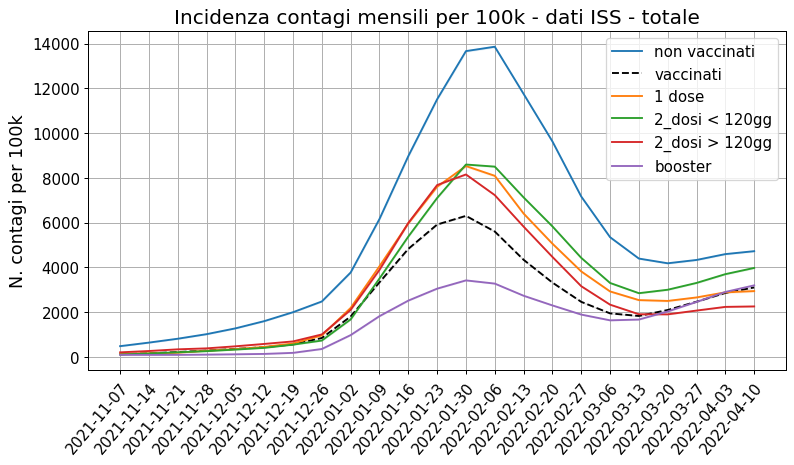

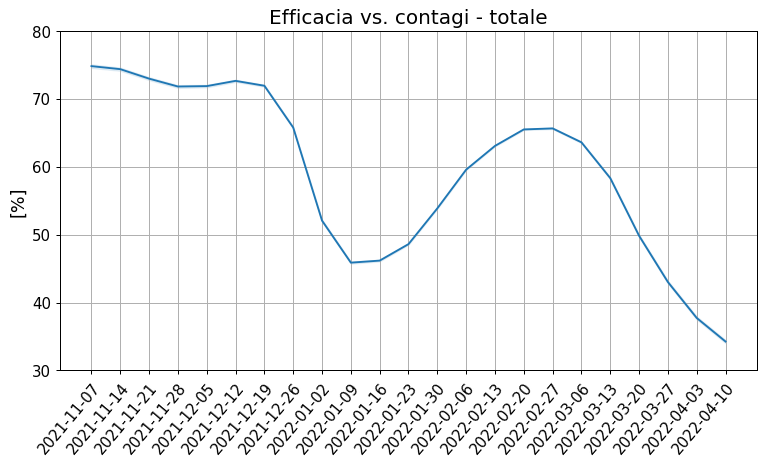

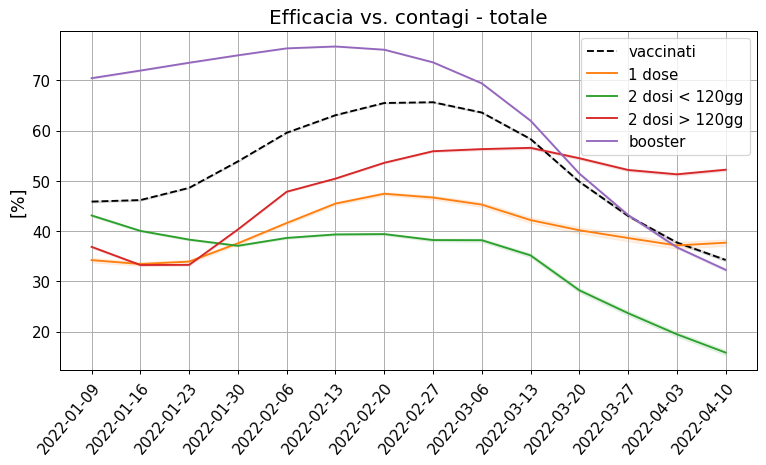

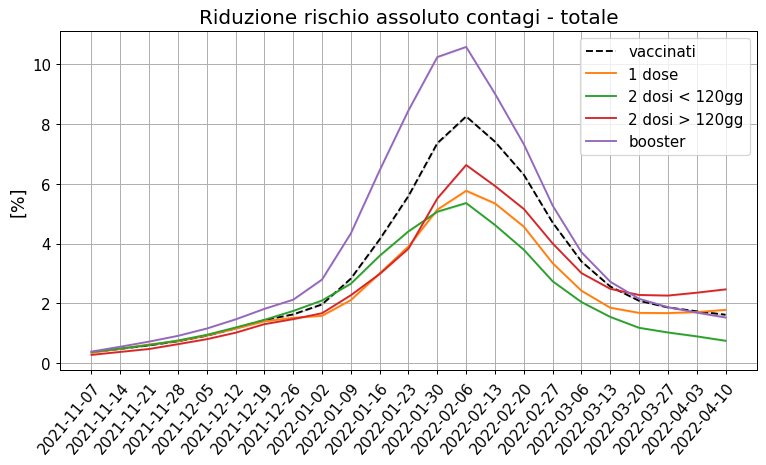

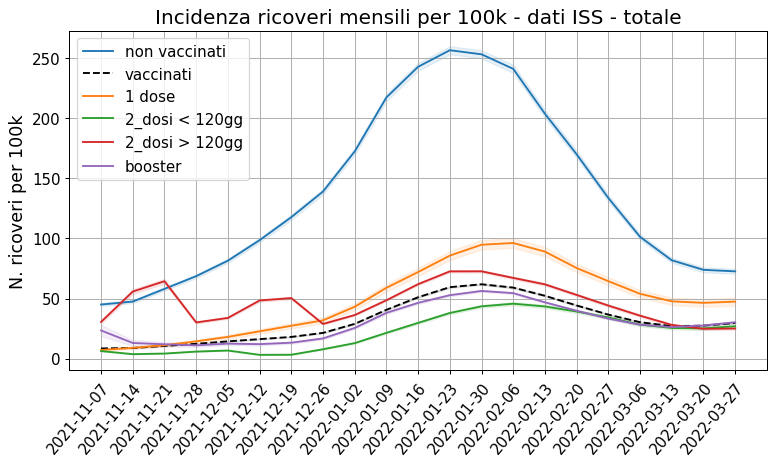

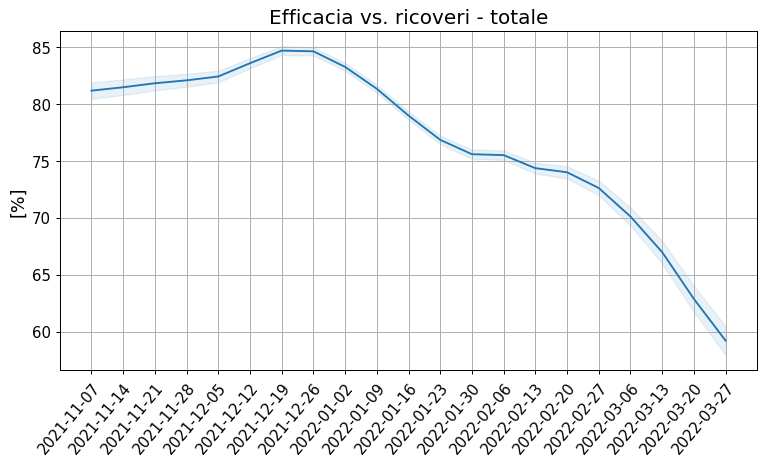

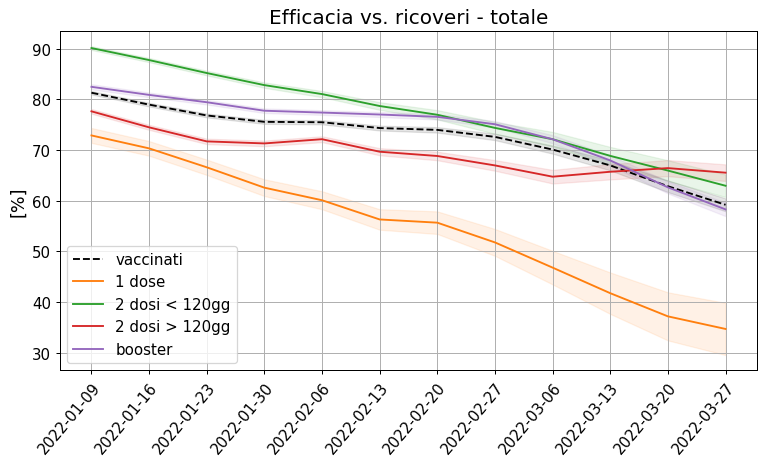

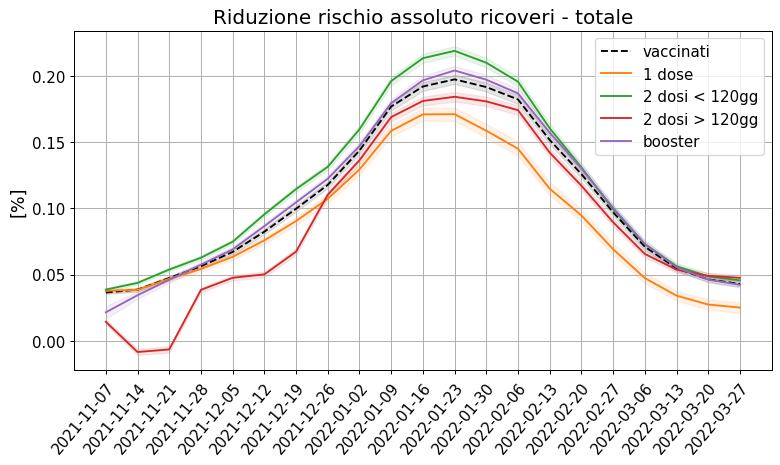

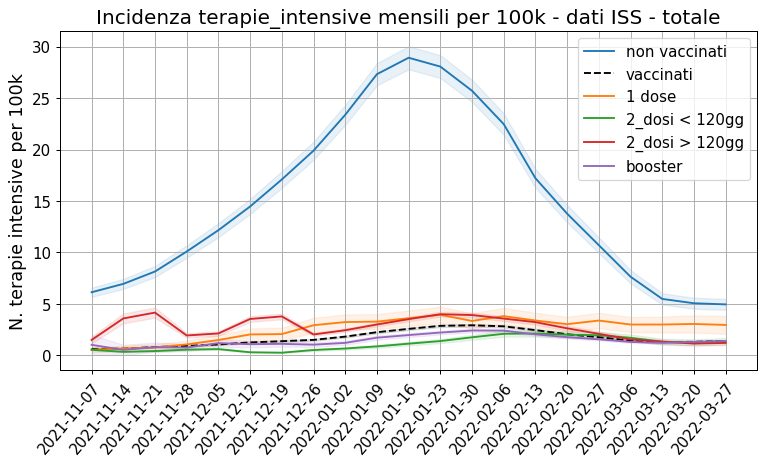

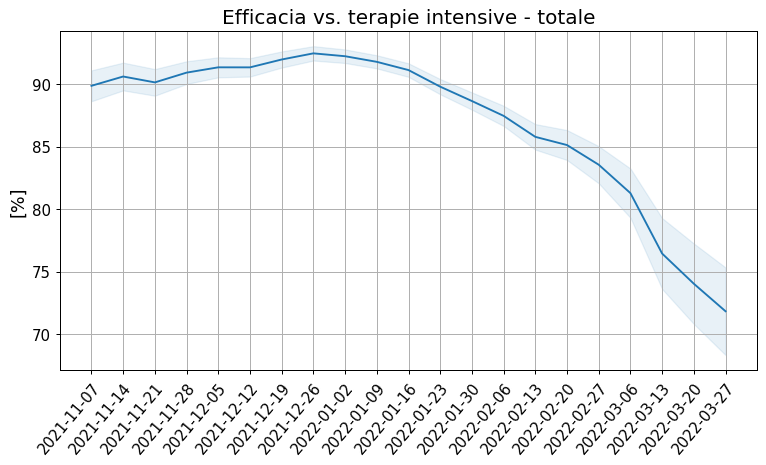

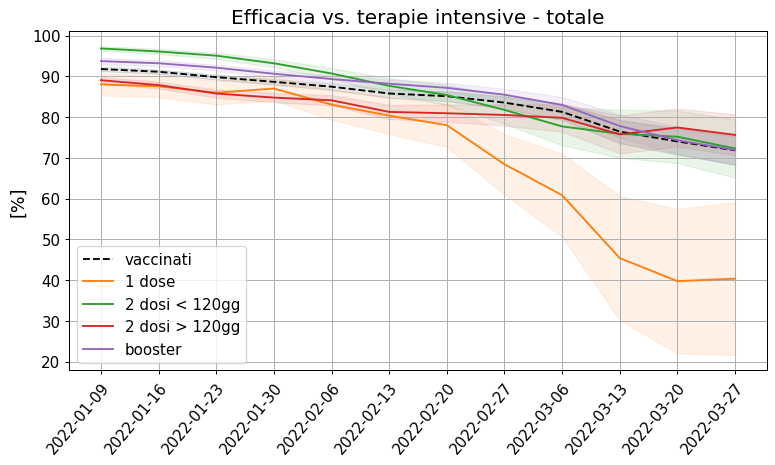

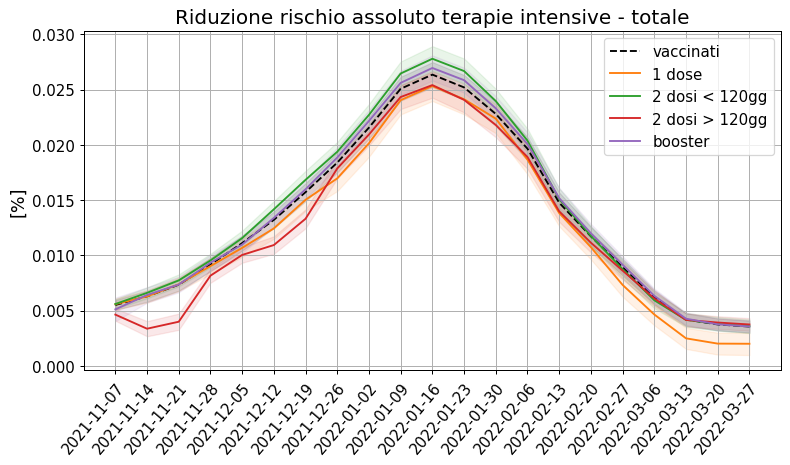

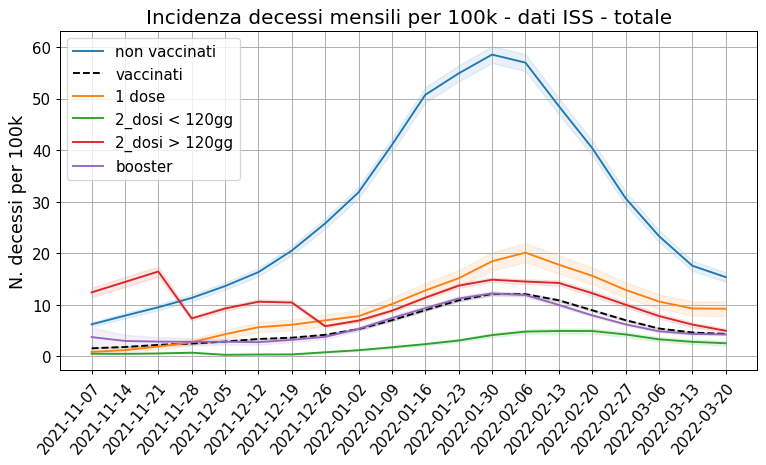

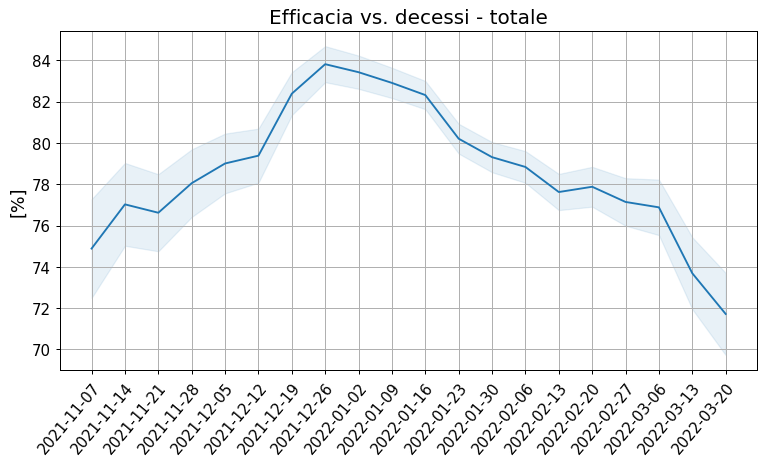

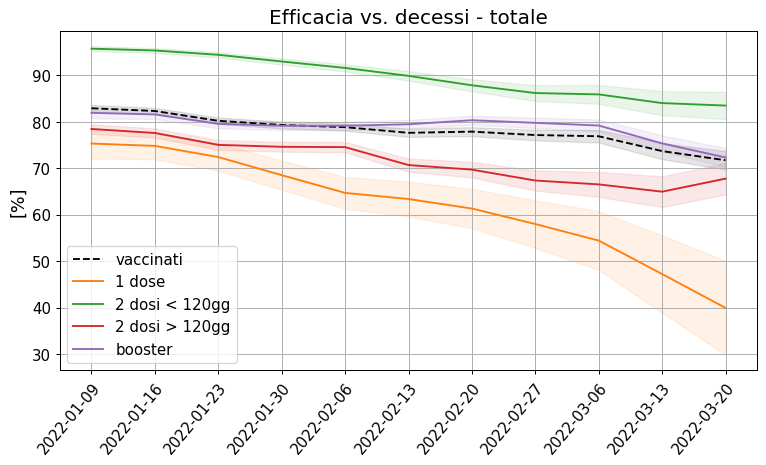

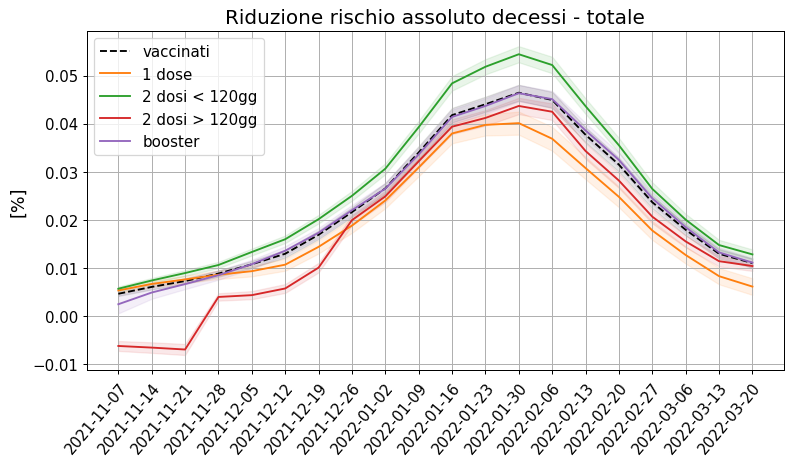

In [45]:
for s in ["contagi","ricoveri","terapie_intensive","decessi"]:
    for eta in df_iss.fascia_eta.unique():
        if eta not in ["totale"]:
            continue
        df_plt = df_iss[(df_iss.split==s) & (df_iss.fascia_eta==eta)]
        df_plt = df_plt.dropna()
        plot_incidence(split=s, age=eta, 
                       colors=[COLORS[0]] + ["black"] + COLORS[1:5],
                       linestyles=["solid","dashed", "solid","solid","solid","solid"]
                      )
        if s == "contagi":
            yticks = list(np.arange(30,90,10))
        else:
            yticks = None
        plot_efficacy(split=s, age=eta, suffix="_all", yticks=yticks)
        plot_efficacy(split=s, age=eta, 
                      cat=["vax", "1_dose", "2_dosi_lt_cut", "2_dosi_gt_cut","booster"],
                      labels=["vaccinati", "1 dose", "2 dosi < 120gg", "2 dosi > 120gg", "booster"],
                      colors=["black"] + COLORS[1:5],
                      linestyles=["dashed","solid","solid","solid","solid"],
                      start_date="2022-01-02"
                     )
        plot_arr(split=s, 
                 age=eta,
                 cat=["vax", "1_dose", "2_dosi_lt_cut", "2_dosi_gt_cut","booster"],
                 labels=["vaccinati", "1 dose", "2 dosi < 120gg", "2 dosi > 120gg", "booster"],
                 colors=["black"] + COLORS[1:5],
                 linestyles=["dashed","solid","solid","solid","solid"],
                )

In [25]:
def plot_vax_vs_no_vax(age: str, 
                       split: str):
    
    plt.figure(dpi=100, figsize=(10,5))
    df_plt = df_iss[(df_iss.fascia_eta==age) & (df_iss.split==split)].reset_index()
    title = f"{split}"
    if age != "totale":
        title += f" {age}"
    createXYPlot(df_plt,
                 y=["no_vax_frac"],
                 labels=["frazione non vaccinati"],
                 colors=["r"],
                 x="data",
                 plots_folder="./plots",
                 days_interval=1,
                 linewidth=1.8,
                 title=title.replace("_"," ")
                )

In [26]:
df_iss["no_vax_frac_err"] = 1.645*np.sqrt((df_iss["no_vax_frac"]*df_iss["vax_frac"])/(df_iss["no_vax"] + df_iss["vax"]))
df_iss["no_vax_frac_err_lo"] = df_iss["no_vax_frac"] - df_iss["no_vax_frac_err"]
df_iss["no_vax_frac_err_hi"] = df_iss["no_vax_frac"] + df_iss["no_vax_frac_err"]

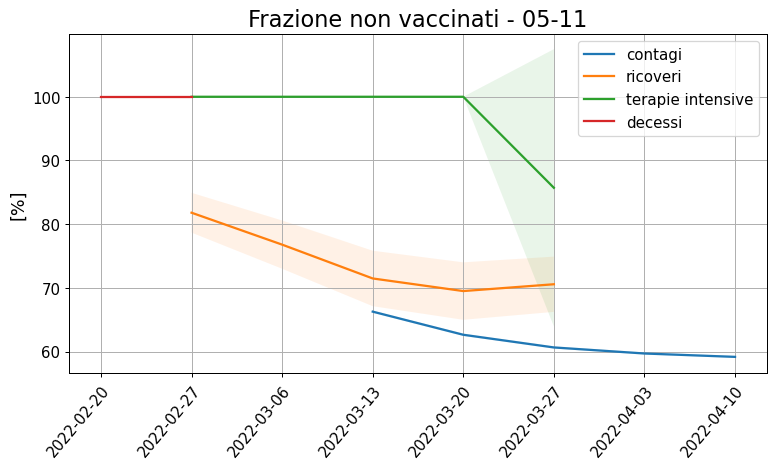

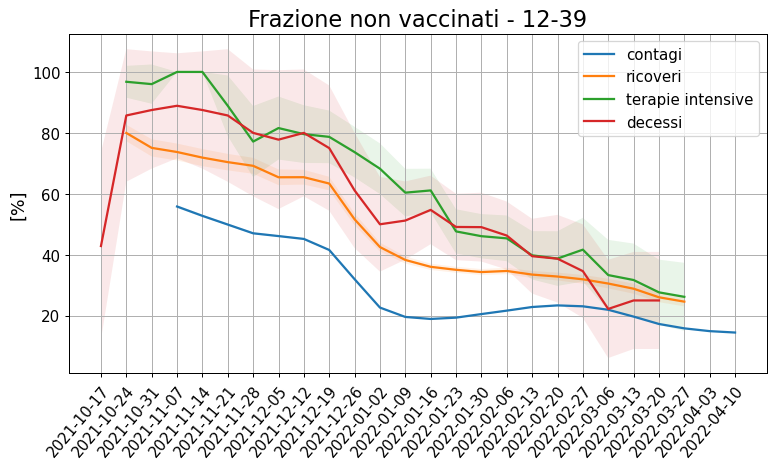

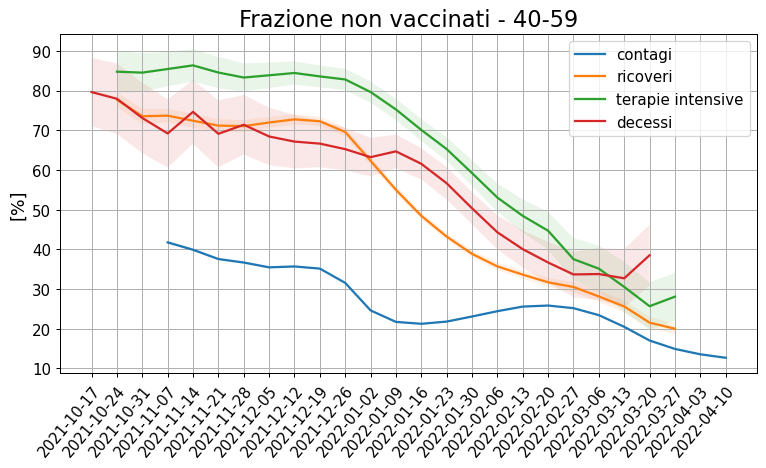

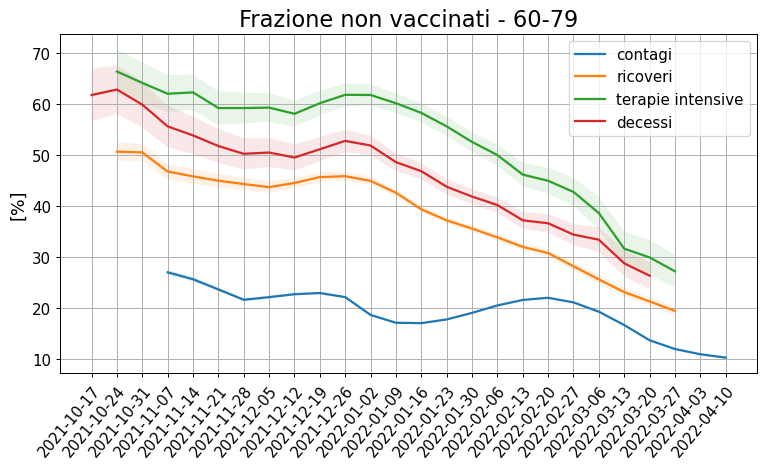

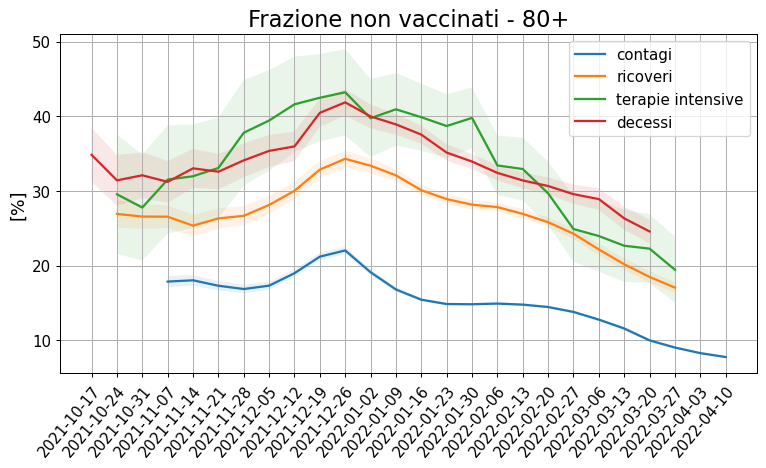

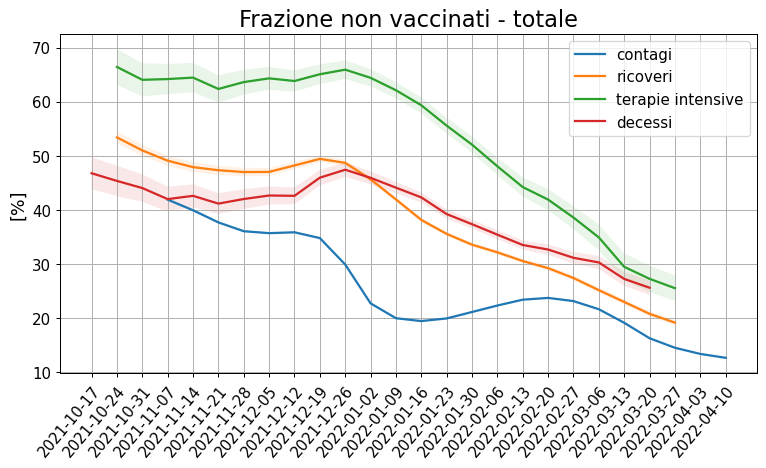

In [27]:
for age in sorted(age_values):
    plt.figure(dpi=90, figsize=(10,5))
    dates_str = []
    dates = []
    for split in ["contagi", "ricoveri", "terapie_intensive", "decessi"]:
        df_plt = df_iss[(df_iss.fascia_eta==age) & (df_iss.split==split)]
        dates_str += [x.strftime("%Y-%m-%d") for x in df_plt.data.unique()]
        dates += [x for x in df_plt.data.unique()]
        plt.plot(df_plt.data,
                 100*df_plt.no_vax_frac,
                 label=split.replace("_"," "),
                 linewidth=1.8
                )
        plt.fill_between(df_plt.data, 
                     100*df_plt.no_vax_frac_err_lo, 
                     100*df_plt.no_vax_frac_err_hi,
                     alpha=0.1
                    )
    title = f"Frazione non vaccinati - {age}"
    plt.title(title, fontsize=18)
    plt.legend(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel("[%]",fontsize=14)
    
    dates_str = sorted(list(set(dates_str)), reverse=False)
    dates = sorted(list(set(dates)), reverse=False)
    plt.xticks(dates,
               dates_str,
               fontsize=12,
               rotation=50, 
               rotation_mode="anchor", 
               verticalalignment = "top",
               horizontalalignment = "right")
    plt.savefig(f"{plots_folder}/frazione_no_vax_{age}", bbox_inches="tight", facecolor="w")

In [28]:
def plot_var_ages(split, varname="vax"):
    plt.figure(dpi=90, figsize=(10,5))
    for age in sorted(age_values):
        df_plt = df_iss[(df_iss.fascia_eta==age) & (df_iss.split=="terapie_intensive")]
        plt.plot(df_plt.data,
            df_plt[varname],
            label=age,
            linewidth=1.8)
    title = f"Totale {varname} {split}".replace("_", " ")
    plt.title(title, fontsize=16)
    plt.grid()
    plt.legend(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(df_plt.data,
               fontsize=12,
               rotation=50, 
               rotation_mode="anchor", 
               verticalalignment = "top",
               horizontalalignment = "right"
              )

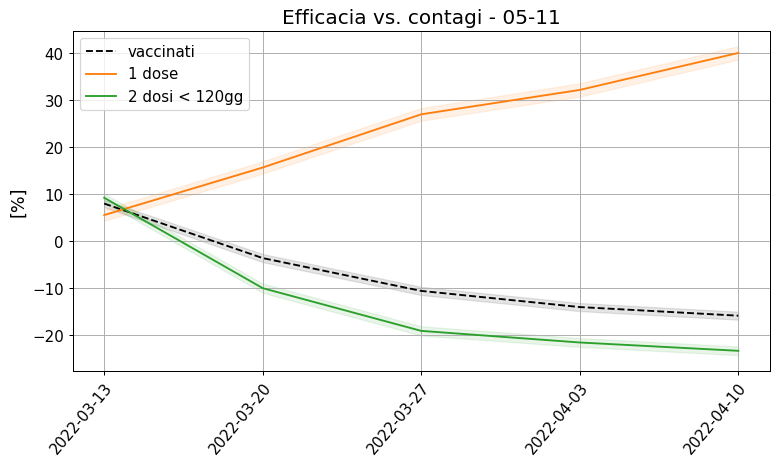

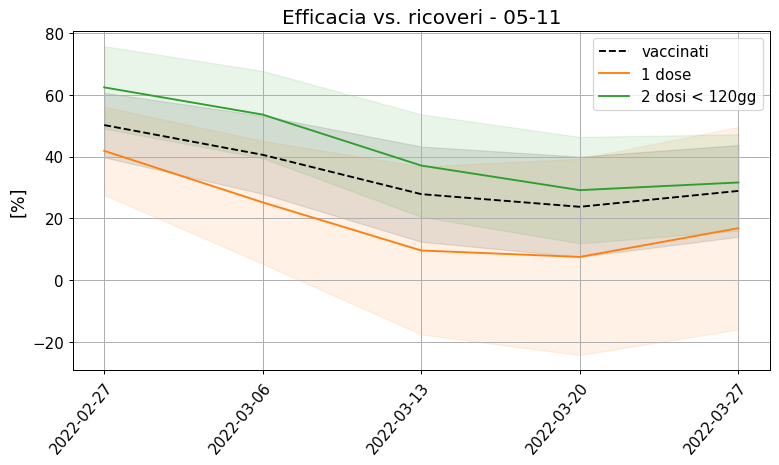

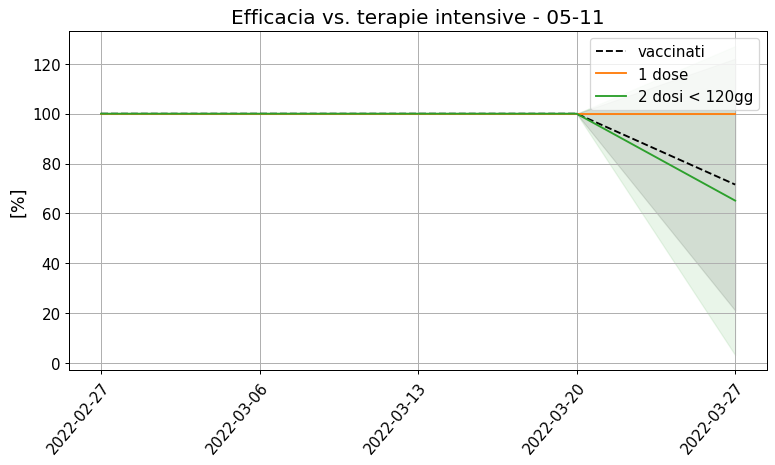

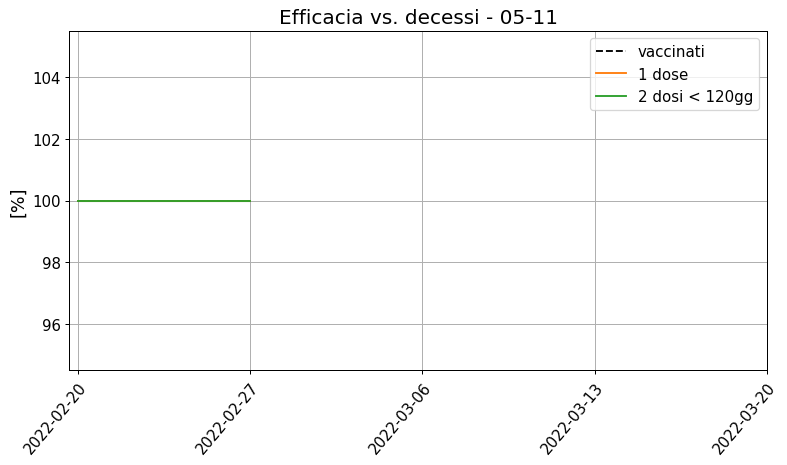

In [29]:
eta="05-11"
for s in ["contagi","ricoveri","terapie_intensive", "decessi"]:
    df_plt=df_iss[(df_iss["fascia_eta"]==eta) & (df_iss.split==s)]
    #plot_incidence(split=s, age=eta)
    plot_efficacy(split=s, age=eta, 
                  cat=["vax", "1_dose", "2_dosi_lt_cut"], 
                  colors=["black"] + COLORS[1:3],
                  linestyles=["dashed","solid","solid"],
                  labels=["vaccinati", "1 dose", "2 dosi < 120gg"])
    #plot_arr(split=s, age=eta)


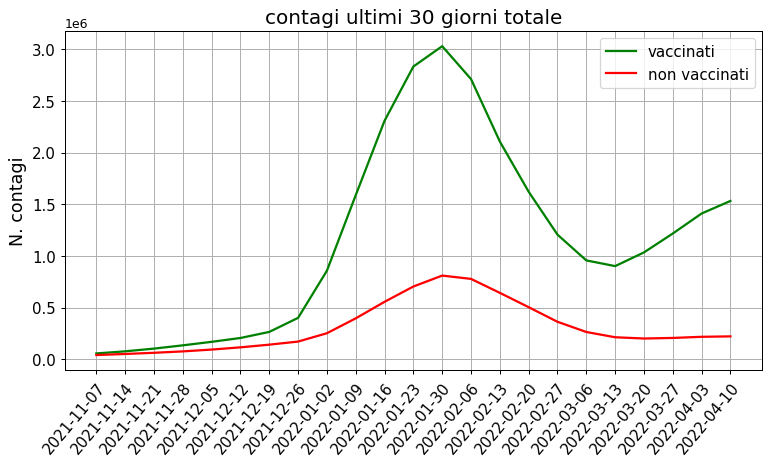

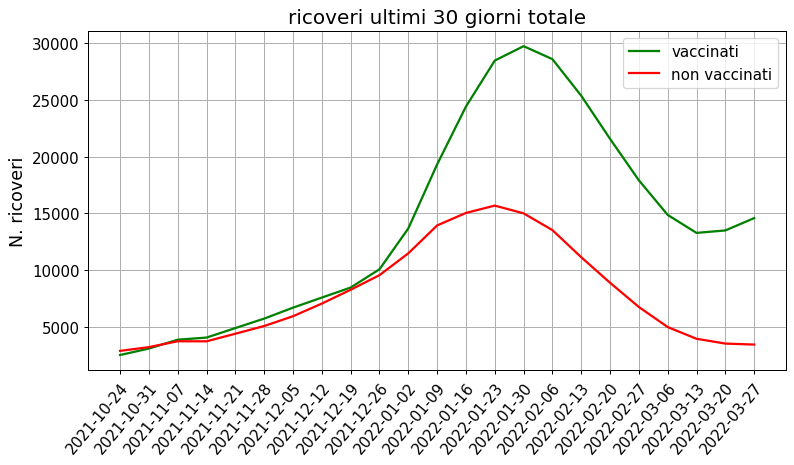

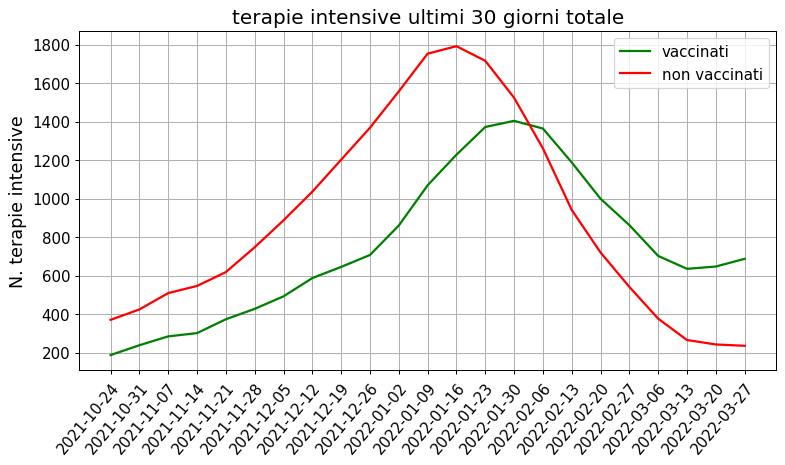

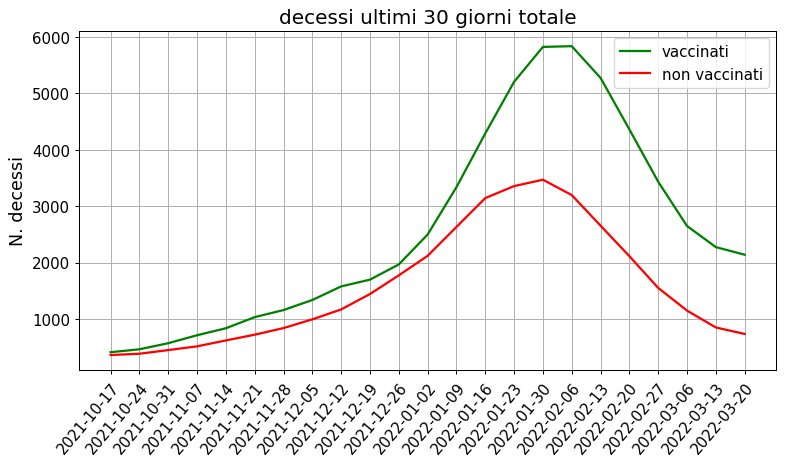

In [30]:
for age in age_values:
    if age != "totale":
        continue
    for split in splits:
        df_plt = df_plt = df_iss[(df_iss.fascia_eta==age) & (df_iss.split==split)]
        savename = f"{split}_{age}"
        yvars = ["vax", "no_vax"]
        savename += "_" + "_".join(yvars)
        createXYPlot(df_plt,
                     y=yvars,
                     x="data",
                     labels=["vaccinati", "non vaccinati"],
                     colors=["g","r"],
                     plots_folder=plots_folder,
                     linewidth=1.8,
                     days_interval=1,
                     title=f"{split} ultimi 30 giorni {age}".replace("_"," "),
                     savename=savename,
                     ytitle=f"N. {split}".replace("_"," "),
                     figsize_x=10,
                     figsize_y=5,
                     dpis=90
                    )

In [31]:
def get_lethality(df: pd.DataFrame, 
                  age: str,
                  savename: str,
                  title: str,
                  yscale: str ="linear",
                  num_den: tuple = ("decessi","contagi"),
                 ):
    
    df_let = df[df.fascia_eta==age]
    value_cols = ["vax",
                  "no_vax",
                  "1_dose",
                  "2_dosi_lt_cut",
                  "2_dosi_gt_cut",
                  "booster",
                 ]
    df_pivot = df_let.pivot(index='data', columns=["split"], values=value_cols)
    cols = []
    for i in range(0,len(df_pivot.columns)):
        cols.append(df_pivot.columns.get_level_values(1)[i] + '_' + df_pivot.columns.get_level_values(0)[i])
    df_pivot.columns = cols
    
    for v in value_cols:
        df_pivot[f"letalita_{v}"] = df_pivot[f"{num_den[0]}_{v}"]/df_pivot[f"{num_den[1]}_{v}"]
        df_pivot[f"sd_letalita_{v}"] = np.sqrt(df_pivot[f"letalita_{v}"] * (1 - df_pivot[f"letalita_{v}"]) / df_pivot[f"contagi_{v}"])
        df_pivot[f"lo_err_letalita_{v}"] = df_pivot[f"letalita_{v}"] - 1.645 * df_pivot[f"sd_letalita_{v}"]
        df_pivot[f"hi_err_letalita_{v}"] = df_pivot[f"letalita_{v}"] + 1.645 * df_pivot[f"sd_letalita_{v}"]
        df_pivot[f"lo_err_letalita_{v}"] = df_pivot[f"lo_err_letalita_{v}"].apply(lambda x: 0 if x < 0 else x)
    
    dates = df_pivot[[f"{num_den[0]}_no_vax",f"{num_den[1]}_no_vax"]].dropna().index
    if age == "totale":
        display(df_pivot[["contagi_no_vax", 
                          "ricoveri_no_vax", 
                          "letalita_no_vax",
                          "contagi_booster", 
                          "ricoveri_booster",
                          "letalita_booster"
                         ]])
        
    plt.figure(figsize=(10,5),dpi=90)
    var_dict = {"no_vax":"non vaccinati", 
                "vax":"vaccinati",
                "1_dose":"1 dose", 
                "2_dosi_lt_cut": "2 dosi < 120gg",
                "2_dosi_gt_cut": "2 dosi > 120gg",
                "booster": "booster"}
    for y in var_dict.keys():
        
        plt.plot(df_pivot.index, 
                 100*df_pivot[f"letalita_{y}"],
                 label=var_dict[y],
                 linewidth=1.8
                )
        plt.fill_between(df_pivot.index, 
                     100*df_pivot[f"lo_err_letalita_{y}"], 
                     100*df_pivot[f"hi_err_letalita_{y}"],
                     alpha=0.1
                    )
    plt.legend(fontsize=12)
    plt.title(f"{title} {age} - dati ISS",fontsize=17)
    plt.ylabel(f"{num_den[0]} / {num_den[1]} [%]".replace("_"," "),fontsize=14)
    _ = plt.yticks(fontsize=13)
    _ = plt.xticks(dates,
                   fontsize=13,
                   rotation=50, 
                   rotation_mode="anchor", 
                   verticalalignment = "top",
                   horizontalalignment = "right"
                  )
    plt.yscale(yscale)
    plt.savefig(f"{plots_folder}/{savename}.png", bbox_inches="tight", facecolor="w")
    return df_pivot

,contagi_no_vax,ricoveri_no_vax,letalita_no_vax,contagi_booster,ricoveri_booster,letalita_booster
data,,,,,,
2021-10-17,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-24,NaN,2890.0,NaN,NaN,17.0,NaN
2021-10-31,NaN,3220.0,NaN,NaN,35.0,NaN
2021-11-07,40182.0,3737.0,0.012817,286.0,69.0,0.038462
2021-11-14,50564.0,3733.0,0.012262,537.0,74.0,0.031657
2021-11-21,61908.0,4402.0,0.011662,969.0,121.0,0.029928
2021-11-28,75512.0,5081.0,0.011111,1710.0,176.0,0.026316
2021-12-05,93220.0,5944.0,0.010663,2652.0,272.0,0.023379
2021-12-12,114674.0,7059.0,0.010203,4219.0,368.0,0.019910


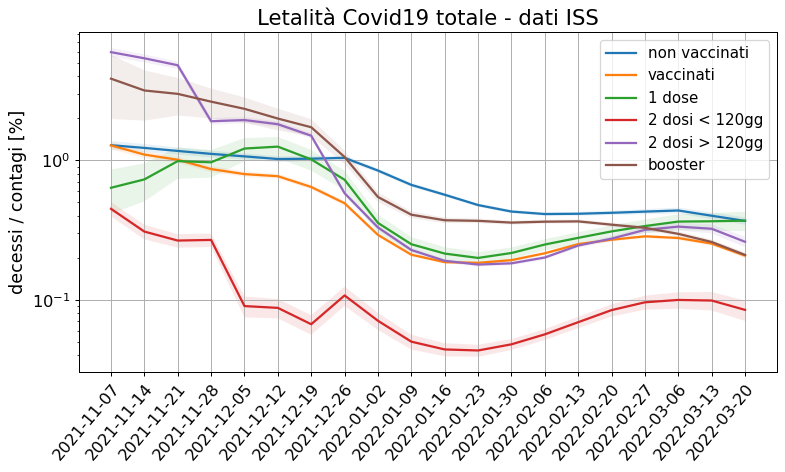

In [32]:
for age in age_values:
    if age != "totale":
        continue
    get_lethality(df_iss,
                  age=age,
                  savename=f"letalita_iss_{age}",
                  title="Letalità Covid19",
                  yscale="log"
                 )

,contagi_no_vax,ricoveri_no_vax,letalita_no_vax,contagi_booster,ricoveri_booster,letalita_booster
data,,,,,,
2021-10-17,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-24,NaN,2890.0,NaN,NaN,17.0,NaN
2021-10-31,NaN,3220.0,NaN,NaN,35.0,NaN
2021-11-07,40182.0,3737.0,0.093002,286.0,69.0,0.241259
2021-11-14,50564.0,3733.0,0.073827,537.0,74.0,0.137803
2021-11-21,61908.0,4402.0,0.071106,969.0,121.0,0.124871
2021-11-28,75512.0,5081.0,0.067287,1710.0,176.0,0.102924
2021-12-05,93220.0,5944.0,0.063763,2652.0,272.0,0.102564
2021-12-12,114674.0,7059.0,0.061557,4219.0,368.0,0.087224


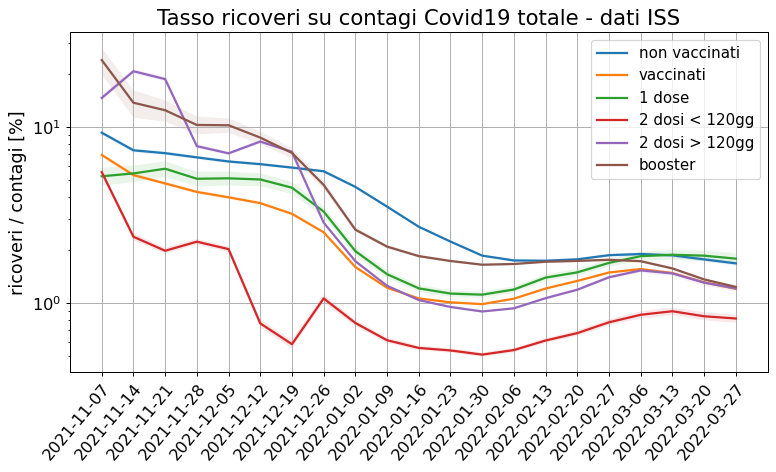

In [33]:
for age in age_values:
    if age != 'totale':
        continue
    get_lethality(df_iss,
                  age=age,
                  savename=f"ricoveri_contagi_iss_{age}",
                  title="Tasso ricoveri su contagi Covid19",
                  yscale="log",
                  num_den=("ricoveri","contagi")
                 )

,contagi_no_vax,ricoveri_no_vax,letalita_no_vax,contagi_booster,ricoveri_booster,letalita_booster
data,,,,,,
2021-10-17,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-24,NaN,2890.0,NaN,NaN,17.0,NaN
2021-10-31,NaN,3220.0,NaN,NaN,35.0,NaN
2021-11-07,40182.0,3737.0,0.012667,286.0,69.0,0.010490
2021-11-14,50564.0,3733.0,0.010798,537.0,74.0,0.005587
2021-11-21,61908.0,4402.0,0.009983,969.0,121.0,0.008256
2021-11-28,75512.0,5081.0,0.009892,1710.0,176.0,0.007018
2021-12-05,93220.0,5944.0,0.009515,2652.0,272.0,0.009804
2021-12-12,114674.0,7059.0,0.009034,4219.0,368.0,0.007822


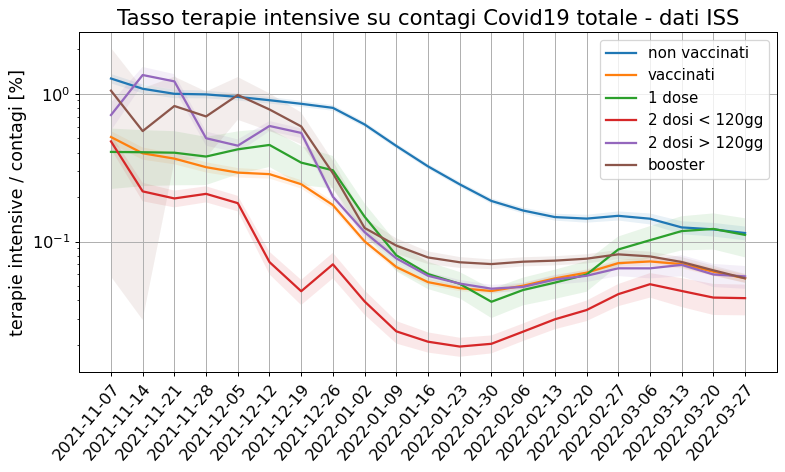

In [34]:
for age in age_values:
    if age != "totale":
        continue
    get_lethality(df_iss,
                  age=age,
                  savename=f"terapie_intensive_contagi_iss_{age}",
                  title="Tasso terapie intensive su contagi Covid19",
                  yscale="log",
                  num_den=("terapie_intensive","contagi"))

In [50]:
df_iss["no_vax_last7"] = df_iss["no_vax"] - df_iss.groupby(["fascia_eta","split"])["no_vax"].shift(1)
df_iss["vax_last7"] = df_iss["vax"] - df_iss.groupby(["fascia_eta","split"])["vax"].shift(1)

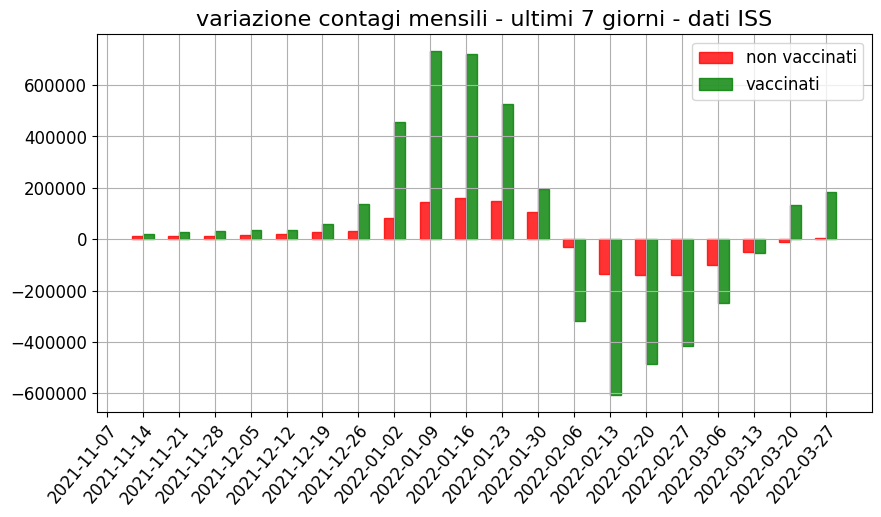

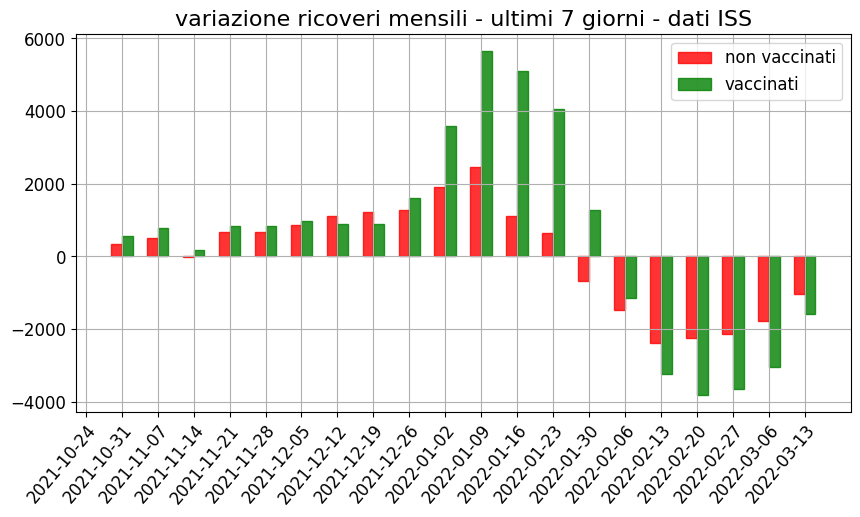

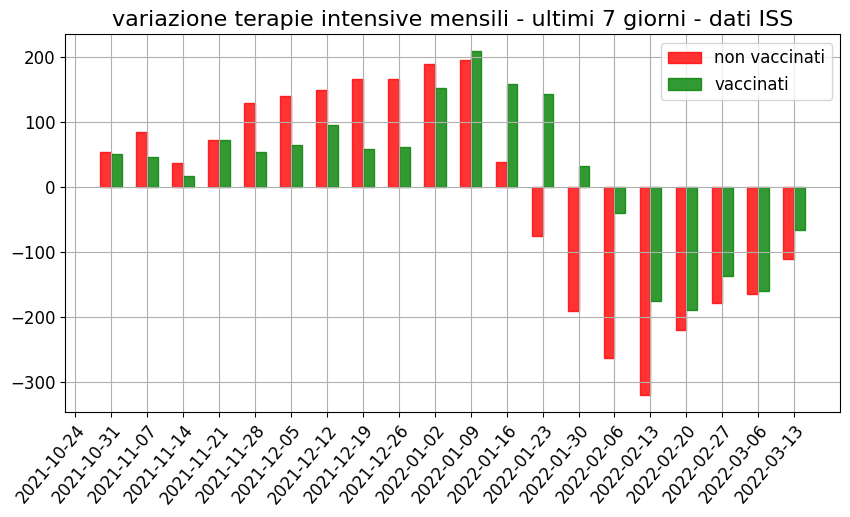

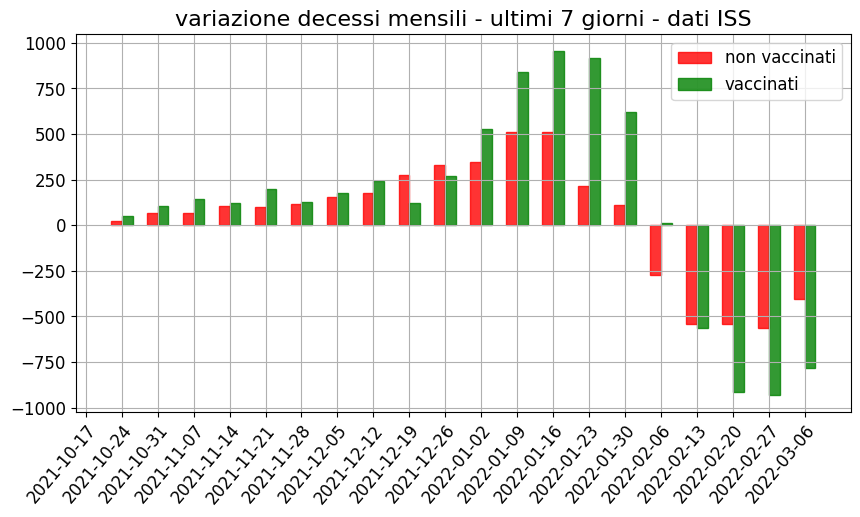

In [51]:
for split in ["contagi", "ricoveri", "terapie_intensive", "decessi"]:
    df_plt = df_iss[(df_iss.fascia_eta=="totale") & (df_iss.split==split)].reset_index()
    createXYPlot(df_plt,
             bar=True,
             bar_start=[-0.5, 0.5],
             alphas=[0.8,0.8],
             bar_width=0.3,
             x="data",
             y=["no_vax_last7","vax_last7"],
             labels=["non vaccinati", "vaccinati"],
             colors=["red","green"],
             linewidth=1.7,
             days_interval=1,
             plots_folder=plots_folder,
             title=f"variazione {split} mensili - ultimi 7 giorni - dati ISS".replace("_"," "),
             savename=f"{split}_ultimi7")

In [ ]:
df_pop

In [ ]:
df_pop_pivot = df_pop.pivot(index=["data_pop"],columns=["fascia_eta"]).reset_index()

In [ ]:
new_col_names = [x[0] + x[1] for x in df_pop_pivot.columns]

In [ ]:
df_pop_pivot.columns = df_pop_pivot.columns.droplevel(0)

In [ ]:
df_pop_pivot.columns = new_col_names

In [ ]:
df_pop_pivot

In [ ]:
from dateutil.relativedelta import relativedelta
path = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df_daily = getVariables(pd.read_csv(path))


df_daily["data"] = pd.to_datetime(df_daily["data"])
df_daily["data"] = df_daily["data"].apply(lambda x: x.date())
df_daily["data_prev"] = pd.to_datetime("2021-12-10")

In [ ]:
df_test = df_daily[(df_daily.data > datetime.strptime("2021-12-10","%Y-%m-%d").date()) & 
         (df_daily.data < datetime.strptime("2022-01-09","%Y-%m-%d").date())][["data","dow","nuovi_positivi"]]

In [ ]:
np.sum(df_test["nuovi_positivi"])

In [ ]:
np.sum(df_contagi[df_contagi.fascia_eta=="totale"][["vax","no_vax"]],axis=1)

In [ ]:
for v in ["ingressi_terapia_intensiva", "nuovi_positivi"]:
    df_daily[f"{v}_last_month"] = df_daily.apply(lambda x: df_daily.loc[(df_daily.data >= x.data_prev) & 
                                                                 (df_daily.data < x.data), v].sum(), axis=1)


In [ ]:
df_ti_comp      = df_ti[df_ti.fascia_eta=="totale"][["data","vax","no_vax"]]
df_contagi_comp = df_contagi[df_contagi.fascia_eta=="totale"][["data","vax","no_vax"]]

df_ti_comp["data"] = pd.to_datetime(df_ti_comp["data"]).apply(lambda x: x.date())
df_contagi_comp["data"] = pd.to_datetime(df_contagi_comp["data"]).apply(lambda x: x.date())

df_daily_comp = df_daily[["data","ingressi_terapia_intensiva_last_month","nuovi_positivi_last_month"]]

In [ ]:
df_comp_contagi = df_daily_comp.merge(df_contagi_comp, on="data", how="inner")
df_comp_contagi["tot"] = df_comp_contagi["vax"] + df_comp_contagi["no_vax"]
df_comp_contagi["diff"] = df_comp_contagi["tot"] - df_comp_contagi["nuovi_positivi_last_month"] 

In [ ]:
df_comp_contagi[["data","nuovi_positivi_last_month","tot","diff"]]

In [ ]:
df_comp = df_daily_comp.merge(df_ti_comp, on="data", how="inner")
df_comp["tot"] = df_comp["vax"] + df_comp["no_vax"]
df_comp["diff"] = df_comp["tot"] - df_comp["ingressi_terapia_intensiva_last_month"] 

In [ ]:
createXYPlot(df_comp,
             x="data",
             y=["diff"],
             title="Differenza bollettino ISS vs. giornaliero (Terapie Intensive)",
             plots_folder=None,
             days_interval=1,
             linewidth=1.8,
             start_date="2021-11-01",
             ytitle="N. ultimi 30gg (ISS - giornaliero)"
            )

In [ ]:
createXYPlot(df_comp_contagi,
             x="data",
             y=["diff"],
             title="Differenza bollettino ISS vs. giornaliero (Contagi)",
             plots_folder=None,
             days_interval=1,
             linewidth=1.8,
             start_date="2021-11-01",
             ytitle="N. ultimi 30gg (ISS - giornaliero)"
            )

In [ ]:
df_comp_contagi

In [ ]:
import pandas as pd
pd.read_csv("https://data.gov.il/dataset/covid-19/resource/8a51c65b-f95a-4fb8-bd97-65f47109f41f/download/event-among-vaccinated-126.csv")